In [12]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *
from scipy.stats import multivariate_normal
import signal
import torch
from torch.distributions.multivariate_normal import MultivariateNormal

In [26]:
def preprocess_program(program):
    p = convert_and_normalize_gm_structure(program)
    p = convert_uniform_structure(p)
    return p


def convert_and_normalize_gm_structure(text):
    # Regular expression to find gm structure
    pattern = r'gm\(\s*(\[[^\]]+\](?:,\s*\[[^\]]+\])*)\s*\)'
    
    # Match all occurrences of the structure
    matches = re.findall(pattern, text)
    
    # Process each match
    converted_text = text
    for match in matches:
        # Find all sets of [pi, mu, s] inside the matched string
        elements = re.findall(r'\[\s*([0-9.-]+)\s*,\s*([0-9.-]+)\s*,\s*([0-9.-]+)\s*\]', match)
        
        # Separate pi, mu, and s into their own lists
        pi_list = [float(e[0]) for e in elements]
        mu_list = [e[1] for e in elements]
        s_list = [e[2] for e in elements]
        
        # Normalize pi_list
        pi_sum = sum(pi_list)
        normalized_pi_list = [pi / pi_sum for pi in pi_list] if pi_sum != 0 else pi_list
        
        # Format the new gm structure with normalized pi_list
        new_gm = f'gm([{", ".join(f"{pi:.6f}" for pi in normalized_pi_list)}], [{", ".join(mu_list)}], [{", ".join(s_list)}])'
        
        # Replace the old structure with the new one in the text
        converted_text = converted_text.replace(f'gm({match})', new_gm)
    
    return converted_text

import re

def convert_uniform_structure(text):
    # Regular expression to find the structure uniform([a, b], c)
    pattern = r'uniform\(\s*\[\s*([0-9.-]+)\s*,\s*([0-9.-]+)\s*\]\s*,\s*([0-9.-]+)\s*\)'
    
    # Find all matches of uniform([a, b], c)
    matches = re.findall(pattern, text)
    
    # Process each match
    converted_text = text
    for match in matches:
        a = float(match[0])  # Extract 'a'
        b = float(match[1])  # Extract 'b'
        c = match[2]         # Extract 'c'
        
        # New value for 'a + b'
        new_b = a + b
        
        # Format the new uniform structure
        new_uniform = f'uniform([{a:.6f}, {new_b:.6f}], {c})'
        
        # Replace the old structure with the new one in the text
        old_uniform = f'uniform([{match[0]}, {match[1]}], {match[2]})'
        converted_text = converted_text.replace(old_uniform, new_uniform)
    
    return converted_text

In [27]:
data_var_list = ['a', 'b']
#data = np.random.uniform(0, 1, 100)
#EXPERIMENT 1
#data = [[np.random.normal(1, 2), np.random.normal(8, 2)] for _ in range(10000)]
#EXPERIMENT 2

data = []
for _ in range(1000):
    a = np.random.normal(1, 2)
    if a < 0:
        b = a * 3
    else: 
        b = np.random.normal(8, 1)
    data.append([a, b])



In [39]:
#EXPERIMENT 1
#text_baseline = 'a = gm([1, 1, 2]);b = gm([1, 8, 2]);'
#text= 'a = uniform([-3, 3], 1);b = uniform([7, 2], 1);'
#text = 'a = gm([1, 1, 2]);b = gm([1, 8, 2]);'
#text = 'a = 8 * uniform([7.000000, 8.800000], 1);\nb = gm([0.264706, 0.735294, 1], [5, 1, 1.4], [1, 8.0, 9.0]) * uniform([2.000000, 9.200000], 6);'
#text = 'b = 6  * e + uniform([3, 7], 1);\nc = 4 * 7;\nc = 5 * gm([0, 6.0, 6], [4, 5, 0]);\nd = 3 - 9;\na = gm([5.7, 0, 0.5]) * gm([8.4, 1.1, 4]);'
#text = 'b = gm([1, 9, 2], [0, 6, 4.5])  - c;\na = gm([6, 1, 2.0]);'
#EXPERIMENT 2
#text = ' a = uniform([5, 7], 1)  - 7;\nb = 1 * gm([9, 8.4, 2], [7, 0, 6]);'
#text = 'a = 9  * a + uniform([0, 7], 1);\nb = gm([8.4, 4.3, 8], [8.1, 9.9, 7])  - 1;'
#text = 'b = e + gm([0.4, 8.8, 1.4], [6, 6.6, 6.4]);\na = gm([1.0, 0.3, 8.0], [3, 5, 1.5]) * uniform([0, 1], 4);'
#text = 'a = uniform([0, 5.1], 1); \nb = 1 * gm([2, 0, 6.3], [2.8, 8, 0.9]);'

#EXPERIMENT 2 HOLES
#text= 'a = gm([4.0, 1.5, 2.3]) ; \nb = gm([2.5, 0, 9], [5.2, 7.1, 2]);\nif a < 0 {\n    b = uniform([0, 1], 3)  - gm([9.8, 5, 6], [4, 4, 1.0]); \n} else { \n   e = gm([0.9, 5, 6], [3.4, 5, 5], [4.7, 2, 1.6]) * uniform([5, 9.4], 1); \n} end if;'
text = 'a = gm([6.1, 1, 2]) ; \nb = gm([6.8, 8.1, 1.0]); \nif a < 0 { \n   e = 9  * d + 4  * c;\n   b = 3 * a; \n} else { \n   c = c * b; \n} end if;'
text_baseline = 'a = gm([1, 1, 2]);\nif a < 0 {\n  b = 3*a;\n} else{ \n  b = gm([1, 8, 1]);\n} end if;'
text_baseline = preprocess_program(text_baseline)
text = preprocess_program(text)
#print(text)
print(text)
compiledText=compile2SOGA_text(text)
compiledText_baseline=compile2SOGA_text(text_baseline)

cfg = produce_cfg_text(compiledText)
cfg_baseline = produce_cfg_text(compiledText_baseline)


output_dist = start_SOGA(cfg)
output_dist_baseline = start_SOGA(cfg_baseline)

a = gm([1.000000], [1], [2]) ; 
b = gm([1.000000], [8.1], [1.0]); 
if a < 0 { 
   e = 9  * d + 4  * c;
   b = 3 * a; 
} else { 
   c = c * b; 
} end if;


In [40]:
# Define a custom exception for timeouts
class TimeoutException(Exception):
    pass

# Define a handler function for the timeout
def handler(signum, frame):
    raise TimeoutException("Code execution exceeded time limit")


def compute_likelihood2(output_dist):
    likelihood = np.zeros(len(data))
    indexes = {element: [index for index, value in enumerate(output_dist.var_list) if value == element] for element in data_var_list}
    marginal_means_components = []
    marginal_covariance_matrices_components = []
    for i in range(output_dist.gm.n_comp()):
        marginal_means = []
        covariance_index = []
        marginal_covariance_matrix = []
        for element, index_list in indexes.items():
            marginal_means.append(output_dist.gm.mu[i][index_list][0])
            covariance_index.append(index_list[0])

        marginal_covariance_matrix.append(output_dist.gm.sigma[i][np.ix_(covariance_index,covariance_index)])
        marginal_means_components.append(marginal_means)
        marginal_covariance_matrices_components.append(marginal_covariance_matrix)

    for j in range(len(data)):
        for i in range(output_dist.gm.n_comp()):
            likelihood[j] = likelihood[j] + output_dist.gm.pi[i] * multivariate_normal.pdf(data[j], mean = marginal_means_components[i], cov = marginal_covariance_matrices_components[i][0], allow_singular=True)

        likelihood[j] = np.log(likelihood[j])
        #log_total_likelihood = log_total_likelihood + np.log(likelihood[j])
    sum_likelihood = np.sum(likelihood)
    #fitness = log_total_likelihood
    fitness = sum_likelihood/len(data)
    return fitness, likelihood

# Main code
try:
    # Set the timeout handler to raise TimeoutException after 5 seconds
    #signal.signal(signal.SIGALRM, handler)
    #signal.alarm(5)  # Set the timeout to 5 seconds
    fitness,l1 = compute_likelihood2(output_dist)
    fitness_baseline, l1 = compute_likelihood2(output_dist_baseline)

    # Cancel the alarm if the code completes within the time limit
    #signal.alarm(0)

except TimeoutException as e:
    print("Caught TimeoutException:", e)

print(fitness)
print(fitness_baseline)

-3.658053650925454
-3.650835770853418


In [35]:
def compute_likelihood_torch(output_dist):
    # Convert data to torch tensors
    data1 = torch.tensor(data, dtype=torch.float32)
    likelihood = torch.zeros(len(data1))

    # Precompute indexes for marginal means and covariance
    indexes = {
        element: torch.tensor([idx for idx, value in enumerate(output_dist.var_list) if value == element])
        for element in data_var_list
    }

    # Stack parameters for all Gaussian components
    pi = torch.tensor(output_dist.gm.pi, dtype=torch.float32)
    mus = torch.stack([torch.tensor(output_dist.gm.mu[i], dtype=torch.float32) for i in range(output_dist.gm.n_comp())])
    sigmas = torch.stack([torch.tensor(output_dist.gm.sigma[i], dtype=torch.float32) for i in range(output_dist.gm.n_comp())])

    # Prepare marginal means and covariance indices
    marginal_means = []
    covariance_indices = []
    for element, index_list in indexes.items():
        marginal_means.append(mus[:, index_list])  # Extract mean vectors
        covariance_indices.append(index_list[0])            # Only unique index per element

    marginal_means = torch.cat(marginal_means, dim=1)  # Combine for all components
    covariance_indices = torch.tensor(covariance_indices)

    # Extract marginal covariance matrices
    marginal_covariances = sigmas[:, covariance_indices][:, :, covariance_indices]

    # Compute likelihoods for all data points
    for j, x in enumerate(data):
        components_likelihoods = 0
        for i in range(output_dist.gm.n_comp()):
            mvn = MultivariateNormal(loc=marginal_means[i], covariance_matrix=marginal_covariances[i])
            print(marginal_covariances[i])
            components_likelihoods += output_dist.gm.pi[i] * torch.exp(mvn.log_prob(torch.tensor(x)))
        
        # Log-sum-exp over components
        likelihood[j] = torch.log(components_likelihoods)

    # Compute total likelihood
    sum_likelihood = torch.sum(likelihood)
    fitness = sum_likelihood / len(data)

    return fitness.item(), likelihood

try:
    # Set the timeout handler to raise TimeoutException after 5 seconds
    #signal.signal(signal.SIGALRM, handler)
    #signal.alarm(5)  # Set the timeout to 5 seconds
    #fitness = compute_likelihood_torch(output_dist)
    fitness_baseline, l2 = compute_likelihood_torch(output_dist_baseline)

    # Cancel the alarm if the code completes within the time limit
    #signal.alarm(0)

except TimeoutException as e:
    print("Caught TimeoutException:", e)

#print(fitness)
print(fitness_baseline)


tensor([[1.0739, 3.2218],
        [3.2218, 9.6653]])
tensor([[1.9447, 0.0000],
        [0.0000, 4.0000]])
tensor([[1.0739, 3.2218],
        [3.2218, 9.6653]])
tensor([[1.9447, 0.0000],
        [0.0000, 4.0000]])
tensor([[1.0739, 3.2218],
        [3.2218, 9.6653]])
tensor([[1.9447, 0.0000],
        [0.0000, 4.0000]])
tensor([[1.0739, 3.2218],
        [3.2218, 9.6653]])
tensor([[1.9447, 0.0000],
        [0.0000, 4.0000]])
tensor([[1.0739, 3.2218],
        [3.2218, 9.6653]])
tensor([[1.9447, 0.0000],
        [0.0000, 4.0000]])
tensor([[1.0739, 3.2218],
        [3.2218, 9.6653]])
tensor([[1.9447, 0.0000],
        [0.0000, 4.0000]])
tensor([[1.0739, 3.2218],
        [3.2218, 9.6653]])
tensor([[1.9447, 0.0000],
        [0.0000, 4.0000]])
tensor([[1.0739, 3.2218],
        [3.2218, 9.6653]])
tensor([[1.9447, 0.0000],
        [0.0000, 4.0000]])
tensor([[1.0739, 3.2218],
        [3.2218, 9.6653]])
tensor([[1.9447, 0.0000],
        [0.0000, 4.0000]])
tensor([[1.0739, 3.2218],
        [3.2218, 9.6

In [36]:
#The elements of l1 and l2 with the same number of decimals

l2 = torch.round(l2, decimals=3)
l1 = torch.tensor(l1, dtype=torch.float32)
l1 = torch.round(l1, decimals=3)
print(l1[1])
print(l2[1])

l1 == l2 #Check if the two likelihoods are the same
#find where they are not the same
print(torch.where(l1 != l2))
print(l1[torch.where(l1 != l2)])
print(len(l1[torch.where(l1 != l2)]))

tensor(-3.6870)
tensor(-3.6870)
(tensor([  0,   2,   7,   9,  10,  17,  19,  20,  21,  24,  25,  29,  36,  39,
         45,  53,  59,  60,  64,  65,  73,  76,  78,  82,  84,  88,  89,  92,
         95,  96,  99, 100, 104, 105, 108, 109, 111, 115, 119, 126, 133, 135,
        140, 148, 150, 151, 152, 163, 167, 168, 170, 171, 175, 176, 181, 184,
        188, 197, 200, 203, 205, 206, 210, 212, 218, 223, 226, 227, 232, 240,
        242, 247, 248, 250, 257, 258, 262, 272, 275, 280, 291, 292, 293, 294,
        298, 299, 306, 307, 309, 315, 324, 326, 328, 330, 332, 336, 338, 341,
        343, 346, 348, 349, 354, 358, 361, 366, 372, 374, 379, 380, 383, 385,
        388, 390, 393, 394, 395, 399, 400, 401, 407, 411, 417, 418, 419, 420,
        422, 424, 426, 427, 431, 432, 436, 439, 442, 445, 446, 452, 454, 455,
        457, 461, 463, 465, 466, 468, 469, 471, 476, 483, 492, 494, 496, 498,
        505, 506, 508, 510, 511, 514, 517, 518, 522, 523, 524, 527, 529, 536,
        540, 544, 546, 549, 556

In [19]:
l2[0].item()

3.1010000705718994

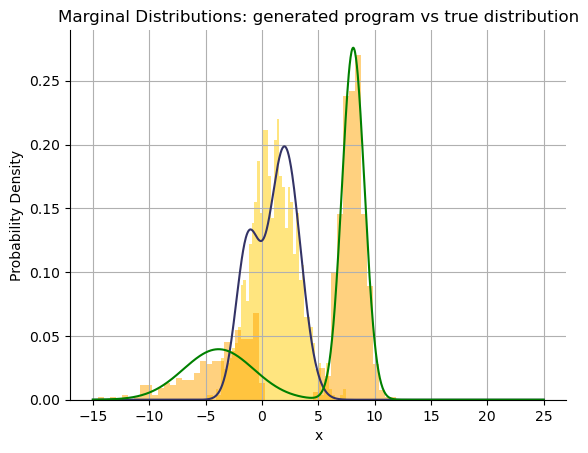

In [37]:
import matplotlib.pyplot as plt
from scipy.stats import uniform

# Define the range for the uniform distribution
x = np.linspace(-15, 25, 1000)
y_0 = [output_dist.gm.marg_pdf(xi,0) for xi in x]
y_1 = [output_dist.gm.marg_pdf(xi,1) for xi in x]

fig, ax = plt.subplots()


ax.plot(x,y_0, label='Program "var 0"', color = '#333366')
ax.plot(x,y_1, label='Program "var 1"', color = 'green')

ax.hist([pair[0] for pair in data], bins=50, density=True, alpha=0.5, color = '#FFCC00')
ax.hist([pair[1] for pair in data], bins=50, density=True, alpha=0.5, color = 'orange')
ax.set_title("Marginal Distributions: generated program vs true distribution")
#ax.set_title("Uniform Distribution (approximation with many components)")
ax.set_xlabel("x")
ax.set_ylabel("Probability Density")

# Remove the upper and right borders
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add grid, legend and show the plot
ax.grid(True)
#ax.legend()
plt.show()



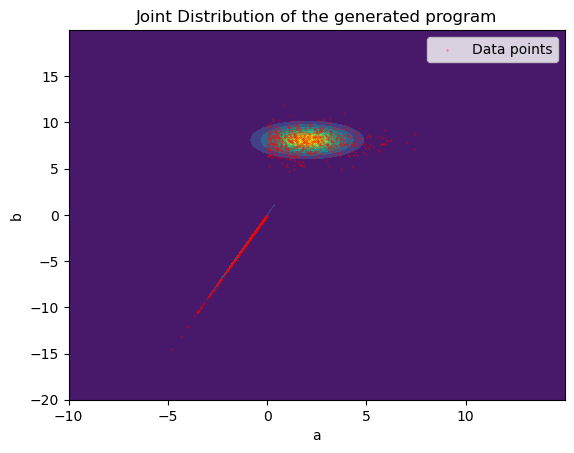

In [38]:
#3D image of the joint distribution
from mpl_toolkits.mplot3d import Axes3D

def get_mixture_pdf1(x, y):
    pdf = 0
    indexes = {element: [index for index, value in enumerate(output_dist.var_list) if value == element] for element in data_var_list}
    for i in range(output_dist.gm.n_comp()):
        marginal_means = []
        covariance_index = []
        for element, index_list in indexes.items():
            marginal_means.append(output_dist.gm.mu[i][index_list][0])
            covariance_index.append(index_list[0])

        marginal_covariance_matrix = output_dist.gm.sigma[i][np.ix_(covariance_index,covariance_index)]
        
        pdf+= + output_dist.gm.pi[i] * multivariate_normal.pdf([x, y], mean = marginal_means, cov = marginal_covariance_matrix, allow_singular=True)

    return pdf

def get_mixture_pdf(point):
    pdf = 0
    indexes = {element: [index for index, value in enumerate(output_dist.var_list) if value == element] for element in data_var_list}
    for i in range(output_dist.gm.n_comp()):
        marginal_means = []
        covariance_index = []
        for element, index_list in indexes.items():
            marginal_means.append(output_dist.gm.mu[i][index_list][0])
            covariance_index.append(index_list[0])

        marginal_covariance_matrix = output_dist.gm.sigma[i][np.ix_(covariance_index,covariance_index)]
        
        pdf+= + output_dist.gm.pi[i] * multivariate_normal.pdf(point, mean = marginal_means, cov = marginal_covariance_matrix, allow_singular=True)

    return pdf
        


x, y = np.mgrid[-10:15:.01, -20:20:.01]
pos = np.dstack((x, y))
#rv = multivariate_normal([0.5, -0.2], [[2.0, 0.3], [0.3, 0.5]])
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y, get_mixture_pdf(pos))
ax2.scatter([pair[0] for pair in data], [pair[1] for pair in data], color = 'red', alpha = 0.7, s = 0.1, label = 'Data points')
ax2.set_title("Joint Distribution of the generated program")
ax2.set_xlabel("a")
ax2.set_ylabel("b")
ax2.legend()